In [1]:
import cv2
import os
import csv
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Conv2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
from keras.layers.core import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
correction=0.25
learning_rate=5e-4
brt = 15

In [3]:
# Option#1
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])
                if abs(center_angle) > 0.013:
                    center_image = cv2.imread(os.path.normpath(batch_sample[0]))
                    #center_image = adjust_gamma(center_image)
                    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2HSV)
                    center_image[:,:,2] += brt
                    images.append(center_image)
                    angles.append(center_angle)
                    #Flipped image
                    center_image_flipped = np.fliplr(center_image)
                    center_image_flipped = cv2.cvtColor(center_image_flipped, cv2.COLOR_BGR2HSV)
                    center_image_flipped[:,:,2] += brt
                    center_angle_flipped = -center_angle
                    images.append(center_image_flipped)
                    angles.append(center_angle_flipped)

                    #Left Image
                    left_image = cv2.imread(os.path.normpath(batch_sample[1]))
                    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2HSV)
                    left_image[:,:,2] += brt
                    left_angle = float(batch_sample[3])+correction
                    images.append(left_image)
                    angles.append(left_angle)
                    #Right Image
                    right_image = cv2.imread(os.path.normpath(batch_sample[2]))
                    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2HSV)
                    right_image[:,:,2] += brt
                    right_angle = float(batch_sample[3])-correction
                    images.append(right_image)
                    angles.append(right_angle)


                    # trim image to only see section with road
                    X_train = np.array(images)
                    y_train = np.array(angles)
                    yield shuffle(X_train, y_train)

In [4]:
# Option#1
samples = []
with open('cardata/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
train_samples, validation_samples = train_test_split(samples, test_size=0.1)
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [5]:
model=Sequential()

# Normalize
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(100,100))))
model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=learning_rate), loss='mse')

In [6]:
# Option#1
_history = model.fit_generator(train_generator, steps_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples),
                    verbose=1, epochs=4)

Epoch 1/4
10536/10536 [==============================] - 286s - loss: 0.0653 - val_loss: 0.0599
Epoch 2/4
10536/10536 [==============================] - 295s - loss: 0.0534 - val_loss: 0.0381
Epoch 3/4
10536/10536 [==============================] - 301s - loss: 0.0463 - val_loss: 0.0358
Epoch 4/4
10536/10536 [==============================] - 295s - loss: 0.0440 - val_loss: 0.0310


In [6]:
# Option#2
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [5]:
# Option#2

images = []
angles = []
with open('cardata\driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for batch_sample in reader:
        center_angle = float(batch_sample[3])
        if abs(center_angle) > 0.013:
            center_image = cv2.imread(os.path.normpath(batch_sample[0]))
            #center_image = adjust_gamma(center_image)
            center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2HSV)
            center_image[:,:,2] += brt
            images.append(center_image)
            angles.append(center_angle)
            #Flipped image
            center_image_flipped = np.fliplr(center_image)
            center_image_flipped = cv2.cvtColor(center_image_flipped, cv2.COLOR_BGR2HSV)
            center_image_flipped[:,:,2] += brt
            center_angle_flipped = -center_angle
            images.append(center_image_flipped)
            angles.append(center_angle_flipped)
        
            #Left Image
            left_image = cv2.imread(os.path.normpath(batch_sample[1]))
            left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2HSV)
            left_image[:,:,2] += brt
            left_angle = float(batch_sample[3])+correction
            images.append(left_image)
            angles.append(left_angle)
            #Right Image
            right_image = cv2.imread(os.path.normpath(batch_sample[2]))
            right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2HSV)
            right_image[:,:,2] += brt
            right_angle = float(batch_sample[3])-correction
            images.append(right_image)
            angles.append(right_angle)
        
X_train = np.array(images)
y_train = np.array(angles)

In [6]:
# Option#2
_history=model.fit(X_train, y_train, validation_split=0.1, shuffle=True, verbose=1, epochs=4)

Train on 30387 samples, validate on 3377 samples
Epoch 1/4
30387/30387 [==============================] - 21s - loss: 0.0686 - val_loss: 0.3556
Epoch 2/4
30387/30387 [==============================] - 20s - loss: 0.0582 - val_loss: 0.2748
Epoch 3/4
30387/30387 [==============================] - 20s - loss: 0.0550 - val_loss: 0.3443
Epoch 4/4
30387/30387 [==============================] - 20s - loss: 0.0512 - val_loss: 0.2622


In [7]:
model.save('model.h5')

In [8]:
### print the keys contained in the history object
print(_history.history.keys())

dict_keys(['val_loss', 'loss'])


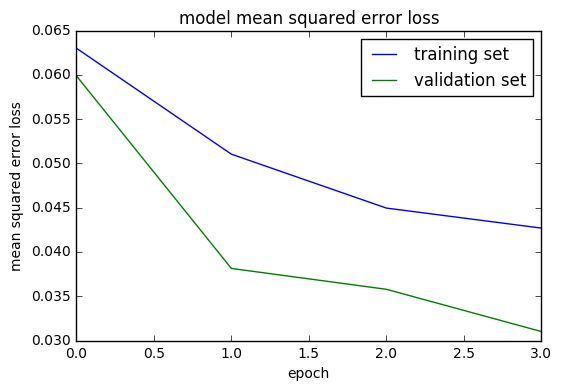

In [9]:
### plot the training and validation loss for each epoch
plt.plot(_history.history['loss'])
plt.plot(_history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [1]:
import numpy as np
import cv2
import scipy.misc
fl_im = np.fliplr(cv2.imread('examples/center_2017_08_25_04_32_33_082.jpg'))
scipy.misc.imsave('examples/center_2017_08_25_04_32_33_082_flipped.jpg', fl_im)